In [ ]:
import numpy as np
import time
import copy as cp

def norm2(v):
  suma = 0
  for i in range(v.size):
    suma += v[i]**2
  return float(suma)

def sortear_en_esfera(dimension):
  ret = [0 for _ in range(dimension)]
  for i in range(dimension):
    ret[i] = np.random.normal()
  ret = np.array(ret)
  ret /= np.linalg.norm(ret)
  return ret


class EigenGame:
  def __init__(self,n,k,components,expected_components,ruido):
    self.n = n #dimension de las muestras
    self.k = k #cantidad de muestras
    self.components = components #componentes principales reales de mi espacio
    self.expected_components = expected_components #cantidad de componentes que quiero hallar
    self.ruido = ruido #ruido que le pongo a las muestas
    self.tiempos = [] #cuanto tiempo tarde en calcular cada componente
    self.iteraciones = [] #cuantas iteraciones tarde en calcular cada componente
    self.id = np.eye(n)
    assert(components >= expected_components)

    dir = np.eye(components,n) #Estas van a ser las componentes principales
    for i in range(components):
      dir[i] = np.random.randint(-k, k, size=n)
    X = np.zeros((k,n))
    weights = np.random.normal(size = (k,components)) #sorteo cuanto de cada componente va a tener cada muestra
    for i in range(k):
      for j in range(components):
        X[i] += dir[j]*weights[i][j]+np.random.rand(n)*ruido #le agrego una componente de ruido aleatoria
    X = X - np.mean(X.T, axis=1)
    self.dir = dir
    self.M = np.matmul(X.T,X) #shape (n,n)
    self.X = X #shape (k,n)

    self.vectors = np.eye(n)
    self.Mv = [np.dot(self.M,self.vectors[i]) for i in range(n)] #vectores de n filas
    self.vtMv = [np.dot(self.vectors[i].T,self.Mv[i]) for i in range(expected_components)]
    self.vMv = np.array([[np.dot(self.vectors[i],self.Mv[j]) for j in range(expected_components)] for i in range(expected_components)])

  def u(self, vector, i):
    Mvector = np.dot(self.M,vector)
    answer = np.dot(vector.T,Mvector)
    for j in range(i):
      answer -= (np.dot(vector.T,self.Mv[j])**2)/self.vtMv[j]
    return answer

  def evolutivo(self,T,error):
    start_time = time.time()
    for i in range(self.expected_components):
      step = 32
      for t in range(T):
        if step < error:
          #print(i+1, t+1,  time.time() - start_time, (time.time() - start_time)/(t+1))
          self.tiempos.append(time.time() - start_time)
          self.iteraciones.append(t)
          start_time = time.time()
          break
        candidato = self.vectors[i]
        utilidad = self.u(candidato,i)
        unmodified = True
        for jj in range(2*self.n):
          j = jj//2
          sumo = True if jj%2==0 else False
          nuevo = self.vectors[i]+step*self.id[j] if sumo else self.vectors[i]-step*self.id[j]
          nuevo /= np.linalg.norm(nuevo)
          utilidad_nueva = self.u(nuevo,i)
          if utilidad_nueva > utilidad:
            candidato = nuevo
            utilidad = utilidad_nueva
            unmodified = False
        if unmodified :
          step /= 2
        else:
          self.vectors[i] = candidato
          self.Mv[i] = np.dot(self.M,self.vectors[i])
          self.vtMv[i] = np.dot(self.vectors[i].T,self.Mv[i])
        if t == T-1:
          print("ATENCION ATENCION ATENCION",i+1, t+1,  time.time() - start_time, (time.time() - start_time)/(t+1))
          self.tiempos.append(time.time() - start_time)
          self.iteraciones.append(t)
          start_time = time.time()
    return self.vectors[0:self.expected_components]

In [ ]:
np.set_printoptions(edgeitems=30, linewidth=100000) #Esto es para ajustar el ancho de la celda

def kill_zeros(matrix):
  copy = matrix
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      if abs(copy[i][j]) < 1e-9:
        copy[i][j] = 0
  return copy

todo = []
for _ in range(2) :
  respuestas = []
  cant_de_muestras = [120,250,500,1000,2000,5000,10000,50000,100000]
  # cant_de_muestras = [1000,50000]
  cant_de_componentes = 10
  for i in cant_de_muestras:
    eg = EigenGame(120,i,10,cant_de_componentes,1)
    v = eg.evolutivo(100000,1e-8)
    print(i,sum(eg.iteraciones) / len(eg.iteraciones))
    respuestas.append(eg.iteraciones)
    print(kill_zeros(np.matmul(v,v.T)))
    print(kill_zeros(np.matmul(v,np.matmul(eg.M,v.T))/(eg.n*eg.n*eg.k*eg.k)))
  print(respuestas)
  todo.append(respuestas)
  print("=================")
print(todo)


120 1834.5
[[ 1.00000000e+00 -6.82102745e-09 -1.85465501e-08 -8.40269185e-09  1.27016308e-08  4.84484014e-09  0.00000000e+00 -1.17783178e-08 -1.16330147e-09  5.56388976e-09]
 [-6.82102745e-09  1.00000000e+00 -3.27462252e-09  5.14193404e-09  1.23302267e-08 -1.25124845e-08 -6.28446052e-09 -4.91571655e-09 -8.72273905e-09 -1.32924389e-08]
 [-1.85465501e-08 -3.27462252e-09  1.00000000e+00  1.45758183e-08  0.00000000e+00 -6.36948256e-09  0.00000000e+00 -1.93760985e-08 -2.85061164e-08  0.00000000e+00]
 [-8.40269185e-09  5.14193404e-09  1.45758183e-08  1.00000000e+00 -6.24876925e-09  2.31487341e-09 -7.11527018e-09  9.07456158e-09  7.97277882e-09  3.71494934e-09]
 [ 1.27016308e-08  1.23302267e-08  0.00000000e+00 -6.24876925e-09  1.00000000e+00  1.16674138e-08 -1.40754777e-09  4.35647013e-09  8.21668258e-09 -9.27311914e-09]
 [ 4.84484014e-09 -1.25124845e-08 -6.36948256e-09  2.31487341e-09  1.16674138e-08  1.00000000e+00 -5.77214452e-09  6.30633702e-09  1.69226612e-08  1.36741036e-08]
 [ 0.000000

In [ ]:
todo_el_experimento = [[[2050, 1495, 1432, 1479, 1409, 1402, 1426, 3461, 1399, 1401], [1398, 2049, 1773, 5406, 1352, 1373, 1383, 1415, 1444, 1376], [1678, 1518, 1589, 1440, 1506, 1551, 1532, 1450, 1762, 1463], [1361, 3924, 1370, 4212, 1520, 2585, 1445, 1566, 1445, 1381], [1446, 1448, 3472, 1422, 4722, 1597, 1421, 1808, 1456, 1412], [1872, 1439, 2212, 1499, 2270, 1851, 1504, 3317, 1443, 1423], [1408, 1850, 5513, 1366, 1406, 1443, 6455, 1477, 2586, 1385], [3178, 1618, 2043, 11738, 1415, 1480, 1592, 3910, 1479, 1400], [1559, 2412, 1515, 2801, 3014, 1442, 12334, 1360, 1558, 1411]],[[1383, 1564, 1521, 1344, 2115, 1455, 1446, 1412, 1426, 1409], [1668, 1487, 1845, 1761, 1409, 4837, 1393, 1428, 1378, 1342], [1485, 1497, 1546, 2676, 1817, 1425, 1426, 1471, 1531, 1398], [1519, 16869, 1451, 2178, 2135, 1478, 1479, 1381, 1441, 1441], [3056, 4618, 1589, 2239, 1694, 1445, 1605, 2106, 1472, 1431], [3774, 1426, 1948, 2183, 1454, 1849, 2578, 1490, 1384, 1421], [1427, 1530, 4029, 2830, 1483, 1358, 1504, 1465, 1705, 1354], [5297, 1447, 1619, 5001, 1462, 2103, 3632, 1594, 1403, 1430], [1792, 1388, 17110, 1371, 1447, 1775, 1691, 1470, 1472, 1475]],[[1398, 5910, 1415, 1378, 1487, 2506, 1415, 1457, 1392, 1373], [1434, 1430, 1767, 1438, 1402, 5540, 1463, 1412, 1533, 1363], [1795, 1409, 1500, 2748, 2587, 1664, 1598, 1416, 1538, 1459], [1545, 1890, 3282, 1433, 1504, 1500, 1478, 1926, 1477, 1436], [1506, 1467, 3528, 1543, 1589, 1953, 1700, 3525, 1420, 1409], [1472, 1534, 2756, 1384, 1384, 1655, 2532, 1390, 1394, 1441], [1539, 1459, 1384, 1701, 2603, 1965, 1487, 1457, 1615, 1388], [1493, 1582, 2569, 1723, 1466, 2008, 1413, 2082, 1432, 1395], [1481, 1905, 4577, 1445, 1414, 1488, 2395, 1513, 1518, 1313]],[[1437, 1669, 1419, 1452, 1501, 1403, 1436, 1475, 1473, 1370], [1481, 2026, 1463, 1419, 1443, 1488, 6838, 1404, 2376, 1380], [1454, 2445, 2922, 2054, 1392, 1435, 1438, 1433, 2219, 1399], [1457, 1422, 2151, 1914, 1494, 1868, 1452, 1535, 1401, 1378], [1728, 1453, 3278, 1415, 1875, 1783, 1495, 6675, 1401, 1364], [1413, 1686, 1556, 1571, 1462, 1475, 1540, 1437, 1555, 1416], [8635, 1585, 2327, 1459, 1543, 1541, 1476, 1611, 1353, 1363], [1543, 1925, 1625, 1438, 1693, 1906, 1560, 1444, 1401, 1473], [1732, 1494, 1545, 6000, 1465, 1554, 2634, 1358, 1665, 1393]],[[1430, 2635, 1443, 1529, 1442, 1779, 1389, 1470, 3392, 1470], [1379, 1620, 1915, 1429, 1477, 1532, 1597, 1475, 1494, 1400], [1530, 1478, 3875, 1525, 1442, 1694, 1608, 1451, 1441, 1368], [1553, 1433, 1474, 1359, 1464, 1642, 1612, 1652, 1405, 1391], [1552, 2214, 1427, 1437, 1508, 4144, 1450, 2463, 1495, 1372], [4474, 1442, 1399, 1476, 1524, 1740, 2148, 2086, 1484, 1432], [1456, 2034, 5132, 2711, 1701, 2345, 1478, 1463, 1404, 1421], [1487, 1506, 4181, 1649, 2054, 3579, 1434, 1395, 1522, 1373], [1403, 1513, 1505, 2572, 3632, 1929, 1443, 1520, 1402, 1439]],[[1435, 1399, 5614, 1431, 1415, 1411, 1399, 3621, 1570, 1398], [1374, 1390, 3619, 1468, 2030, 1437, 1743, 1443, 1507, 1431], [1461, 2423, 1483, 1522, 1451, 1459, 1709, 3339, 1493, 1358], [1420, 1506, 1819, 1432, 1602, 2760, 1505, 1450, 1933, 1427], [1562, 1408, 1465, 1704, 2872, 4995, 1448, 1463, 1456, 1411], [1571, 1446, 7369, 1484, 1826, 3159, 7646, 1460, 1472, 1355], [1450, 1409, 1885, 1436, 2539, 1487, 1553, 1639, 1457, 1358], [1556, 5127, 1470, 1629, 1609, 1508, 1378, 1437, 1738, 1469], [1686, 1535, 2680, 3124, 1407, 1343, 1491, 24675, 1418, 1414]],[[1461, 1442, 1506, 1534, 1393, 1426, 1409, 1430, 1468, 1423], [1444, 1522, 1430, 1515, 1930, 1414, 1431, 1428, 1358, 1373], [1440, 1415, 1560, 6833, 1448, 1433, 4997, 1554, 3013, 1405], [1666, 1419, 1699, 1503, 3328, 2330, 1477, 1634, 1496, 1350], [1539, 1458, 1670, 1488, 1579, 1495, 2484, 1516, 1407, 1406], [1496, 1496, 1485, 1393, 1638, 2333, 1480, 1603, 1446, 1477], [1427, 2010, 2699, 1501, 1690, 1397, 3569, 1383, 1409, 1408], [1474, 1462, 10603, 1957, 1489, 2253, 1456, 1552, 1591, 1431], [2205, 1477, 2609, 1508, 1560, 1356, 1683, 1574, 1405, 1394]],[[1447, 1538, 1388, 2031, 1368, 1383, 1416, 1466, 1419, 1397], [1525, 1458, 1764, 2279, 1494, 1507, 1408, 1431, 1457, 1469], [1455, 2867, 1431, 1702, 3078, 1557, 2109, 2641, 1563, 1495], [1445, 1502, 1800, 1401, 1436, 2324, 1827, 3999, 1332, 1391], [1429, 1476, 2151, 1503, 2632, 1516, 1418, 1511, 1493, 1428], [1526, 1397, 1706, 5112, 1990, 1854, 5414, 1472, 1402, 1385], [1501, 1597, 2295, 1506, 1400, 1505, 1560, 2004, 1419, 1382], [1444, 1539, 1466, 1621, 3944, 2006, 1367, 1419, 1421, 1384], [7792, 1446, 1645, 1860, 4391, 1422, 1932, 2213, 1394, 1375]],[[1377, 1592, 1505, 1428, 1473, 2481, 3662, 1475, 1515, 1419], [1425, 1437, 1472, 1475, 1437, 2600, 1526, 1450, 1431, 1427], [2007, 1492, 2165, 1415, 2036, 1411, 1591, 1456, 1379, 1424], [2223, 1479, 1430, 1416, 1526, 1611, 1454, 2834, 1376, 1448], [2423, 1500, 2119, 2417, 1500, 1427, 1587, 1511, 1417, 1362], [1377, 1497, 1495, 1643, 1790, 1375, 1473, 1729, 3651, 1407], [2751, 1492, 1531, 18563, 1403, 1513, 1677, 1591, 1420, 1381], [5508, 1437, 2505, 2074, 1465, 2956, 1541, 1467, 1652, 1413], [12756, 2474, 4210, 1388, 1777, 1981, 1650, 1450, 1478, 1414]],[[1435, 1458, 1693, 1475, 1480, 1861, 1417, 1400, 1419, 1357], [1478, 1439, 1525, 2350, 1779, 1401, 1514, 1399, 1398, 1444], [1975, 1550, 1376, 1654, 2939, 1432, 1435, 1453, 1399, 1393], [1589, 1411, 1783, 1411, 1520, 1904, 2713, 1457, 1442, 1392], [1393, 2873, 1446, 1431, 1483, 1586, 2203, 1430, 1438, 1401], [2622, 1624, 5628, 1515, 1497, 1469, 1883, 1490, 1500, 1356], [2089, 1381, 1504, 1497, 1402, 1735, 1438, 1880, 1613, 1385], [6004, 1429, 2559, 6617, 1474, 1474, 1601, 1514, 1381, 1376], [1969, 1518, 1453, 1770, 2645, 1452, 1492, 1634, 1377, 1460]],[[1754, 1437, 8127, 1387, 1387, 2144, 1444, 1372, 2202, 1413], [1828, 2387, 1523, 1456, 1856, 1448, 1430, 1339, 1464, 1363], [1419, 1420, 2073, 1523, 1692, 1386, 1632, 1434, 1416, 1426], [1454, 1947, 2208, 2139, 1433, 1546, 1417, 1449, 1488, 1406], [1384, 1850, 3746, 1431, 1393, 3701, 1832, 1456, 1398, 1498], [2758, 1611, 4336, 1448, 1568, 10345, 1499, 1509, 2209, 1419], [1472, 1786, 1488, 1431, 3656, 1387, 1475, 1523, 1468, 1398], [4722, 1483, 1916, 1470, 1591, 1532, 1730, 1474, 1451, 1379], [4768, 1406, 2117, 1366, 2263, 1481, 2770, 1585, 1613, 1428]],[[1764, 1450, 1444, 1588, 1484, 1492, 3465, 1463, 1404, 1396], [14157, 1396, 1608, 2491, 1637, 1429, 1471, 1442, 2460, 1354], [1382, 1464, 1459, 1993, 1759, 1506, 1442, 1417, 1736, 1422], [1845, 1481, 2055, 1626, 1504, 1757, 1812, 1397, 5430, 1375], [1379, 2618, 1462, 11530, 1520, 1515, 1410, 1580, 1399, 1430], [1852, 1578, 1390, 1676, 2480, 1416, 1463, 1377, 1413, 1380], [1454, 2643, 1546, 1567, 1612, 1435, 1431, 1818, 1395, 1431], [1491, 2954, 1459, 2362, 6016, 2286, 1400, 1452, 3073, 1401], [1472, 1576, 1476, 2742, 1389, 1721, 3474, 1506, 1987, 1400]],[[1414, 3843, 2126, 1408, 2923, 1375, 1443, 1447, 1450, 1344], [2465, 3618, 1432, 1466, 1415, 1392, 1430, 1449, 1414, 1451], [1570, 1920, 1531, 1521, 1410, 1558, 1479, 2712, 1420, 1412], [1693, 1584, 2220, 1490, 3291, 1571, 2414, 1426, 1433, 1437], [1406, 1472, 1902, 1593, 3481, 1491, 1476, 1548, 1427, 1354], [1419, 1522, 1570, 2007, 2488, 1740, 3337, 1450, 1453, 1426], [1481, 1472, 1540, 3350, 1352, 3170, 1504, 1426, 1661, 1466], [1591, 1988, 1581, 1514, 1607, 1382, 1712, 1515, 1467, 1372], [1419, 1577, 1485, 4522, 2650, 1834, 1531, 1403, 1523, 1355]],[[1537, 2762, 1472, 1451, 1519, 1552, 2843, 1427, 1376, 1443], [1523, 1510, 1410, 1393, 1431, 1461, 3823, 1530, 1428, 1426], [2750, 1493, 1472, 6204, 1652, 1390, 1422, 5069, 1373, 1400], [1585, 1801, 1636, 2099, 1440, 1874, 1392, 1718, 1398, 1391], [1453, 1577, 1567, 3984, 2271, 1644, 1491, 1476, 1488, 1466], [2420, 1465, 1435, 1470, 2028, 1490, 1402, 1827, 1429, 1394], [1670, 2039, 1504, 2702, 1518, 17795, 1392, 1447, 1418, 1543], [2103, 1786, 1589, 1582, 1444, 1409, 1817, 1714, 1438, 1443], [4477, 1571, 3353, 1887, 1487, 3490, 1534, 1535, 1410, 1434]],[[1452, 1792, 1457, 1380, 1429, 1696, 1449, 1426, 1373, 1457], [3959, 1411, 1396, 1500, 4978, 1363, 1465, 1578, 1407, 1412], [1444, 1677, 1472, 1427, 1434, 1906, 1364, 1474, 1502, 1414], [1494, 1530, 2250, 1492, 1453, 2371, 1436, 1380, 1444, 1376], [1439, 1423, 1476, 1447, 3266, 1440, 1716, 1517, 1414, 1401], [1375, 1453, 1494, 7707, 1650, 1444, 1456, 18701, 1399, 1433], [1439, 3690, 1506, 2518, 1605, 2297, 1361, 1474, 3234, 1456], [1561, 3654, 1373, 3007, 2931, 1583, 1544, 1359, 1510, 1373], [1468, 1913, 1457, 1497, 1545, 3220, 1704, 1450, 1429, 1353]],[[1472, 1655, 5066, 1534, 1321, 1433, 1504, 1436, 1444, 1381], [1536, 1669, 3036, 1463, 1394, 1777, 1359, 1498, 1897, 1379], [1420, 1615, 1784, 1528, 1570, 1735, 1502, 2466, 1437, 1374], [1955, 1414, 4551, 4586, 1490, 1445, 1492, 1479, 2117, 1419], [4545, 1544, 1569, 1615, 1351, 1454, 1350, 1357, 1473, 1399], [1409, 1560, 1947, 1568, 16356, 1580, 5227, 1446, 1635, 1393], [4173, 1384, 1719, 1502, 1462, 1419, 4116, 2443, 1375, 1399], [10576, 1446, 2175, 2321, 1377, 1447, 1492, 1758, 1454, 1354], [1704, 1674, 2492, 1532, 1485, 2668, 1409, 1365, 1398, 1416]],[[1415, 1439, 1697, 1422, 1479, 1455, 1392, 1413, 1427, 1456], [1492, 18136, 4707, 1410, 2582, 1724, 7084, 5631, 1410, 1340], [1447, 1460, 3452, 1478, 1462, 3277, 1412, 1648, 1467, 1376], [1562, 1989, 1464, 5080, 1365, 1538, 13095, 1431, 1449, 1402], [1409, 14808, 1504, 1454, 2902, 1439, 1761, 2066, 1391, 1383], [1400, 2195, 1573, 1525, 2530, 1379, 3314, 1446, 2016, 1410], [2552, 2507, 1488, 1673, 2063, 1719, 1573, 1476, 1404, 1385], [1383, 2261, 1508, 1862, 1388, 1431, 1553, 1449, 1458, 1427], [3771, 1537, 4166, 1365, 1423, 1508, 1435, 1435, 1412, 1385]],[[1405, 1425, 1443, 1542, 1436, 3165, 1436, 1449, 1432, 1400], [1409, 1427, 2015, 1558, 1508, 1480, 1442, 1980, 1456, 1384], [2551, 1391, 1525, 1409, 1472, 2078, 1540, 2122, 1377, 1408], [1415, 1422, 7844, 1351, 1448, 1506, 1667, 2744, 1386, 1359], [1445, 1685, 1523, 2768, 1486, 1459, 1456, 1421, 1390, 1446], [1414, 2016, 1350, 1368, 1504, 1687, 2640, 7511, 1432, 1375], [1519, 1765, 2237, 1470, 2703, 1404, 1443, 1775, 2004, 1412], [1479, 2497, 2890, 1546, 1619, 1437, 1735, 1480, 1393, 1396], [1517, 1727, 1568, 1574, 1515, 7692, 1497, 1468, 1497, 1355]],[[1401, 34869, 1424, 1518, 1549, 1464, 1870, 2262, 1426, 1368], [1478, 3009, 1436, 1644, 1448, 2095, 1368, 1424, 1838, 1412], [1440, 1392, 1507, 1707, 2532, 1464, 1376, 1434, 1487, 1422], [2894, 1449, 1556, 2403, 1512, 1466, 1406, 1517, 5417, 1330], [1564, 1724, 1917, 1539, 1700, 1462, 1462, 1490, 3321, 1360], [1488, 1518, 1621, 1451, 2326, 1413, 1623, 1474, 2654, 1398], [1598, 1600, 3703, 1544, 3222, 1605, 1440, 1420, 1634, 1391], [1427, 1404, 1998, 1544, 1483, 1491, 1622, 1599, 1416, 1430], [1469, 1409, 9261, 1409, 1375, 2013, 1964, 1428, 1557, 1392]],[[1442, 1356, 1500, 1422, 3186, 1407, 1361, 1468, 1405, 1397], [1422, 1450, 1424, 1392, 1541, 2468, 1528, 1460, 1446, 1369], [1848, 1396, 6505, 1395, 1816, 1472, 2530, 1558, 1577, 1421], [1441, 1466, 1617, 1432, 2135, 1504, 2399, 1509, 1850, 1378], [4516, 1462, 1394, 1429, 1418, 2535, 1630, 1457, 1466, 1429], [1559, 1476, 1570, 1584, 1455, 2773, 1895, 1352, 1330, 1436], [1466, 9857, 1853, 2830, 1418, 1554, 1431, 1475, 1405, 1397], [1460, 1517, 5493, 2791, 2415, 1411, 1945, 1486, 1519, 1457], [1673, 1452, 2301, 3237, 1646, 4661, 1431, 1407, 2045, 1391]],[[1617, 1381, 1704, 1387, 1418, 1975, 1442, 1414, 1387, 1394], [1459, 1446, 1697, 1451, 1413, 1445, 1487, 1398, 1387, 1487], [1707, 1432, 2556, 1417, 1830, 1379, 1427, 1453, 1550, 1424], [1407, 3468, 1493, 1754, 1706, 1880, 1441, 1457, 1411, 1351], [1425, 2025, 1609, 1350, 2616, 1366, 1433, 1477, 1513, 1394], [2532, 1468, 1909, 1662, 4186, 1439, 1375, 2750, 1431, 1383], [2746, 1509, 1448, 1424, 1416, 1626, 2914, 4424, 1430, 1400], [1584, 2383, 1591, 2037, 1488, 1585, 1441, 2510, 1451, 1364], [1703, 23362, 1540, 1458, 2036, 2104, 1403, 1596, 1424, 1349]],[[1394, 1427, 1473, 1426, 1490, 1410, 1514, 1423, 1409, 1464], [1663, 2470, 1499, 3029, 1377, 1471, 1455, 1425, 1386, 1451], [1494, 1422, 1642, 3914, 1607, 1639, 1491, 1426, 1976, 1368], [1490, 2190, 1646, 1554, 1520, 1500, 2078, 1538, 1483, 1477], [1410, 1438, 1485, 1552, 1444, 1378, 2165, 1420, 1376, 1447], [1763, 1758, 1468, 8119, 2458, 1884, 2319, 1458, 1333, 1411], [1438, 1496, 12691, 1534, 1630, 1802, 1915, 1540, 1418, 1440], [1410, 1634, 1479, 1389, 1478, 1895, 1528, 2121, 1462, 1387], [1524, 1375, 1376, 2920, 1567, 1592, 3319, 1400, 1372, 1370]],[[1525, 1570, 1431, 1564, 1463, 6501, 1440, 3360, 1375, 1473], [1416, 1498, 1610, 1924, 1405, 1421, 2269, 1429, 1401, 1429], [1693, 1424, 1354, 2897, 2988, 1530, 1715, 1461, 1425, 1404], [2149, 1476, 1453, 1735, 1434, 1388, 1800, 1415, 1536, 1381], [1372, 2126, 1475, 1475, 1987, 1584, 2632, 1422, 1526, 1371], [5673, 1837, 2164, 1466, 1449, 1548, 4327, 1567, 1546, 1417], [1584, 1598, 1416, 3387, 1628, 2574, 2663, 1426, 1443, 1397], [36597, 1516, 1567, 1530, 1462, 1486, 1640, 1421, 1436, 1384], [1472, 1536, 1594, 1865, 2022, 2023, 1507, 2251, 1398, 1421]],[[1411, 2608, 1479, 1543, 1405, 1426, 2024, 1420, 1425, 1396], [1429, 2072, 1421, 1532, 1475, 5110, 1395, 1416, 1448, 1390], [1820, 1403, 2265, 1478, 2300, 1467, 1429, 2023, 1400, 1443], [1457, 1730, 2098, 1554, 2571, 1389, 1506, 1539, 1363, 1478], [1524, 2759, 1510, 1402, 2415, 4431, 1383, 1518, 1379, 1351], [1771, 1483, 1542, 2428, 1535, 1479, 1423, 1805, 1429, 1398], [1487, 1443, 1459, 6119, 1737, 4358, 1582, 3318, 1511, 1393], [3410, 1731, 1408, 2785, 1394, 2676, 1452, 1482, 1588, 1381], [1497, 1520, 1529, 1561, 14080, 2270, 1404, 1423, 1408, 1402]],[[1560, 1459, 1895, 1536, 1417, 1435, 1510, 1424, 1417, 1457], [1404, 1443, 1482, 1525, 2102, 1515, 1589, 1460, 1649, 1397], [1374, 1510, 1446, 1619, 2532, 1397, 1620, 1423, 1433, 1346], [1400, 2522, 1391, 1488, 1738, 3446, 1451, 1362, 1374, 1408], [1468, 7018, 1437, 2302, 1573, 2198, 1464, 1433, 1400, 1477], [1468, 2638, 1420, 2006, 1498, 1427, 1438, 1537, 1426, 1373], [1491, 1402, 1661, 1713, 3702, 3537, 2291, 1360, 1542, 1429], [1537, 1447, 1561, 1579, 1746, 1722, 4326, 1423, 1428, 1405], [1502, 1714, 1527, 1453, 1406, 3559, 1485, 1382, 1413, 1391]],[[1402, 1647, 2650, 1487, 1450, 1504, 1413, 1370, 1385, 1352], [1409, 1476, 2052, 1419, 2568, 1659, 2276, 1472, 1538, 1340], [1429, 1634, 1491, 1479, 1402, 1398, 1640, 2513, 1435, 1375], [1483, 1400, 1854, 2680, 1475, 1453, 2293, 1477, 1417, 1414], [2258, 1418, 1803, 7772, 1428, 1381, 1480, 1507, 1429, 1464], [1992, 1445, 1500, 1850, 1508, 1475, 1930, 1481, 1444, 1409], [1522, 4117, 2305, 1471, 1629, 1494, 2747, 1386, 1371, 1362], [1483, 1441, 1492, 1482, 2035, 1445, 5939, 2434, 1442, 1349], [1460, 3028, 1423, 3121, 1978, 2929, 1489, 3301, 4735, 1426]],[[1485, 1450, 1415, 1646, 1414, 1490, 1510, 1388, 1399, 1375], [1733, 1422, 1996, 2750, 1434, 1457, 1504, 4017, 1420, 1385], [1511, 3102, 1445, 1461, 3068, 1474, 1500, 1503, 1464, 1402], [1397, 1984, 1494, 1431, 1885, 1467, 1510, 1478, 2318, 1359], [6236, 1527, 1664, 1425, 1597, 1514, 1515, 2842, 1414, 1430], [2187, 1435, 1949, 1496, 1584, 2886, 1570, 1752, 1467, 1421], [2065, 1409, 1525, 2604, 1396, 1818, 1500, 1380, 1379, 1379], [1417, 1491, 15010, 1461, 10001, 1470, 7819, 1548, 1404, 1434], [1728, 1416, 1461, 1744, 1542, 1446, 2852, 2387, 1400, 1389]],[[1445, 1435, 1494, 1416, 1857, 1431, 1503, 1434, 1393, 1339], [1546, 1465, 2061, 1382, 1510, 1449, 1425, 2394, 1460, 1430], [1956, 1340, 1398, 1794, 1510, 1445, 1475, 1491, 1415, 1362], [1387, 2520, 2318, 1435, 3720, 1408, 1538, 1377, 2933, 1385], [1446, 4030, 1585, 1501, 1465, 2002, 2704, 1595, 1380, 1438], [1394, 1397, 1848, 1479, 1627, 1877, 1445, 1460, 1391, 1426], [1838, 1433, 2305, 1440, 1536, 1375, 1434, 2694, 1392, 1341], [1469, 1407, 1501, 1737, 1534, 3806, 1395, 1994, 1498, 1451], [2542, 1747, 1449, 1417, 1488, 1421, 1821, 1485, 1451, 1427]],[[1359, 1454, 1454, 1489, 1616, 1530, 1771, 1447, 1346, 1470], [1484, 6184, 1619, 1481, 1430, 1408, 1448, 1377, 1450, 1384], [1516, 1486, 1748, 1412, 1558, 1461, 1424, 1426, 1432, 1407], [2627, 1841, 1694, 18925, 2076, 2749, 1381, 1500, 1506, 1410], [1472, 1524, 1884, 1405, 2561, 1503, 2483, 2074, 1352, 1432], [14900, 1432, 1903, 1559, 1612, 1473, 1651, 1431, 1369, 1368], [1413, 1574, 1554, 1437, 2722, 1455, 1653, 1408, 6996, 1390], [1493, 40371, 1459, 1424, 2439, 1500, 1563, 1671, 1426, 1413], [1414, 2040, 1454, 1635, 1449, 1472, 1609, 1455, 1452, 1419]],[[1353, 1618, 1431, 1454, 1457, 1470, 1469, 1419, 1360, 1465], [1436, 1539, 1583, 1411, 1544, 3709, 1458, 1387, 1419, 1447], [2554, 1367, 2710, 1480, 4086, 1536, 1588, 1456, 1409, 1421], [1425, 1437, 1624, 2357, 1416, 1710, 1520, 1393, 4914, 1414], [2113, 2419, 1537, 1544, 3212, 9885, 1452, 1498, 1697, 1403], [1554, 2347, 1509, 1388, 1484, 1393, 1365, 3026, 1502, 1384], [3333, 1581, 1479, 1500, 2469, 1411, 1514, 4687, 1653, 1430], [1865, 1696, 1450, 1640, 1592, 1337, 1491, 1769, 1369, 1397], [1970, 1537, 1457, 1815, 1542, 7126, 2185, 1384, 1515, 1410]],[[1400, 3392, 1480, 1452, 1418, 1386, 1434, 1384, 1381, 1427], [1632, 1356, 1605, 1919, 1383, 1485, 2071, 1476, 2197, 1429], [1992, 1491, 1563, 1627, 1446, 1499, 2047, 1455, 1397, 1356], [1407, 1430, 3238, 1614, 1443, 1542, 1453, 1386, 1448, 1403], [2239, 1723, 1551, 1648, 3365, 1849, 1432, 1478, 1449, 1419], [7246, 1532, 2138, 1993, 1629, 1892, 1661, 1486, 2361, 1422], [1437, 1617, 2206, 1467, 1506, 6212, 1514, 1422, 1507, 1401], [4642, 1524, 1728, 1729, 1452, 1468, 1935, 1559, 1484, 1382], [1391, 4082, 1475, 1590, 1549, 3127, 1489, 1442, 1472, 1432]],[[1394, 4188, 1465, 2086, 1481, 1374, 1428, 1430, 2060, 1417], [1475, 1537, 2808, 2767, 1753, 1395, 1378, 1433, 1342, 1395], [1467, 1723, 1623, 1605, 1486, 1395, 1819, 1767, 1443, 1420], [1465, 1610, 1555, 1873, 1405, 1561, 1455, 1437, 2855, 1417], [1594, 3160, 1491, 1847, 1410, 1662, 1539, 1388, 1460, 1360], [1417, 1422, 1571, 1403, 1416, 1679, 1418, 1561, 1742, 1380], [1504, 6803, 1567, 1383, 1539, 1378, 1489, 1464, 1497, 1441], [1525, 3434, 1526, 1623, 1674, 2021, 1487, 1345, 1447, 1430], [2232, 1423, 2114, 1982, 1666, 1770, 2462, 1426, 1420, 1434]],[[1435, 1494, 1661, 1816, 1425, 1454, 1474, 3190, 1370, 1386], [1568, 1555, 1439, 1557, 1772, 1603, 1448, 1353, 1449, 1400], [2248, 1441, 1509, 1473, 1420, 1840, 5380, 1520, 1522, 1394], [1804, 1505, 1492, 1451, 1623, 1500, 1616, 2005, 1410, 1439], [1541, 2629, 3507, 1361, 2596, 2602, 1424, 1375, 1433, 1424], [1553, 2256, 1445, 1447, 3003, 3376, 1393, 1526, 1503, 1374], [1464, 1586, 1483, 2246, 9039, 1549, 1479, 1461, 1457, 1428], [1459, 1583, 1363, 1510, 18765, 1539, 1596, 1507, 1399, 1376], [2822, 1401, 1482, 2253, 1605, 4571, 1513, 1455, 1436, 1439]],[[1585, 1400, 1541, 1483, 2182, 1490, 1417, 1429, 2135, 1360], [1390, 1439, 1426, 1499, 1780, 8257, 1391, 1397, 1420, 1441], [1440, 3113, 1755, 1438, 1987, 1515, 2085, 1406, 1436, 1410], [1454, 2027, 1479, 1834, 1393, 4455, 3688, 1375, 5040, 1375], [2252, 1502, 1463, 1818, 1482, 3368, 5049, 1457, 1396, 1429], [1431, 1403, 1541, 3180, 2273, 2548, 1540, 1845, 1357, 1423], [1475, 1460, 1411, 4037, 1550, 2825, 1537, 1712, 1430, 1467], [1800, 1400, 1395, 1439, 1766, 1881, 1545, 11190, 1460, 1400], [1477, 1461, 4244, 1535, 6016, 1486, 1445, 1598, 1489, 1397]],[[1394, 1538, 1526, 1418, 1513, 2947, 1468, 1434, 1470, 1361], [1468, 1771, 1385, 2609, 1676, 1514, 1529, 1448, 1617, 1397], [1615, 1493, 1485, 1568, 1396, 1512, 1503, 9297, 1444, 1416], [1467, 1694, 1704, 1551, 1433, 1656, 1490, 1530, 1465, 1393], [1405, 2592, 1449, 1474, 1456, 1418, 1592, 1364, 1953, 1499], [1536, 1461, 1466, 1623, 1528, 1476, 1421, 2354, 1530, 1410], [2076, 1505, 1707, 2796, 1539, 1525, 1493, 1590, 1408, 1437], [1407, 2781, 1580, 1446, 2654, 1458, 1554, 1717, 1541, 1404], [1406, 3308, 1522, 1475, 3621, 4009, 1426, 1435, 2983, 1386]],[[3054, 5249, 1398, 1466, 1821, 1453, 1422, 1460, 1440, 1368], [1433, 1357, 1539, 1459, 3036, 2086, 8071, 1414, 2223, 1534], [1423, 1385, 1412, 1503, 1797, 2009, 2288, 3240, 1460, 1410], [1658, 1361, 3295, 1395, 1858, 1567, 2532, 1762, 1473, 1432], [2378, 1472, 1412, 1519, 1477, 3434, 2434, 2188, 1461, 1431], [2521, 1642, 1399, 1816, 1472, 1716, 1494, 1460, 1393, 1347], [1682, 1584, 2521, 1511, 1463, 1506, 2998, 1472, 1821, 1448], [1453, 1366, 1772, 1390, 1616, 2683, 1906, 1551, 1397, 1361], [1446, 2118, 1965, 1665, 1490, 1443, 1459, 1552, 1452, 1428]],[[1535, 1402, 1369, 31495, 1432, 1462, 8087, 1427, 1480, 1473], [1360, 1809, 1445, 1488, 1431, 1461, 2664, 1407, 1601, 1361], [1453, 1403, 1447, 1682, 1422, 1462, 1574, 1667, 1417, 1438], [1446, 1668, 3136, 1424, 1436, 3617, 1464, 1386, 1414, 1361], [1472, 1509, 2721, 1386, 1579, 1422, 3976, 1414, 1465, 1388], [1448, 2266, 1502, 2653, 1596, 2370, 1439, 1444, 1410, 1397], [1401, 2077, 1452, 4839, 1428, 1575, 6860, 6488, 1437, 1359], [1411, 1568, 26647, 1574, 1579, 2177, 1466, 1451, 3062, 1457], [2231, 1455, 1551, 2020, 1511, 1415, 1509, 14563, 1420, 1378]],[[1602, 6246, 1461, 1442, 1426, 1466, 1494, 1482, 1460, 1440], [1407, 1533, 2439, 1400, 1513, 1374, 1712, 1723, 1636, 1414], [1777, 1424, 1424, 1511, 2670, 1449, 2928, 1721, 1408, 1368], [1438, 3251, 1397, 9518, 3949, 1391, 1497, 4327, 1384, 1460], [1471, 1880, 1438, 2092, 1586, 1527, 2336, 1468, 1487, 1429], [2621, 1419, 1463, 1465, 1456, 1523, 1520, 1449, 1510, 1373], [1772, 1466, 1773, 2413, 1758, 1369, 1402, 1472, 1448, 1415], [1373, 1525, 2341, 1366, 2260, 1440, 1507, 1461, 1422, 1394], [1462, 4073, 1909, 5303, 1451, 11112, 1505, 1503, 1369, 1390]],[[1522, 1498, 1426, 2708, 1478, 1406, 1882, 1332, 1474, 1444], [2357, 1440, 1428, 1602, 1484, 1504, 1497, 1428, 1430, 1427], [1657, 1482, 1769, 1426, 1437, 1454, 1431, 2664, 1522, 1440], [2356, 1585, 1568, 1522, 1704, 2188, 1701, 1528, 1430, 1394], [1556, 2561, 1431, 1458, 1424, 1427, 1368, 1356, 1389, 1429], [3638, 1506, 1491, 1474, 1487, 1596, 1548, 1478, 1427, 1320], [1472, 2272, 3961, 1622, 1390, 1425, 1677, 1408, 1387, 1386], [2254, 2031, 1494, 1994, 1661, 1410, 1454, 1408, 1584, 1460], [2632, 1429, 1553, 2790, 2294, 1500, 1613, 3709, 1401, 1432]],[[1532, 1456, 1543, 1380, 1467, 1436, 1475, 1334, 1370, 1421], [1424, 1430, 1414, 1631, 1456, 4818, 1418, 1471, 1403, 1378], [1450, 1362, 1423, 1471, 1743, 1458, 2358, 2350, 1441, 1503], [1372, 1523, 1610, 4450, 1410, 1496, 1473, 1345, 1479, 1428], [2654, 4567, 1499, 1681, 2334, 1412, 5008, 1558, 1518, 1465], [1380, 2360, 1566, 2246, 1411, 1514, 1378, 1422, 1504, 1425], [1480, 1450, 1439, 1680, 1612, 1518, 1829, 1463, 1615, 1401], [1447, 1500, 1427, 1451, 1876, 1511, 1646, 1445, 1437, 1419], [1439, 3065, 1426, 2587, 1466, 1823, 2630, 2105, 1435, 1354]],[[1395, 1397, 1456, 4367, 1427, 2690, 1999, 1381, 1409, 1389], [1414, 1377, 1587, 1491, 1384, 1717, 1738, 2354, 1451, 1419], [1605, 1494, 1520, 1682, 1457, 1605, 1380, 1603, 1404, 1423], [1466, 6781, 4043, 1801, 3738, 1469, 1417, 5007, 1363, 1346], [10496, 1426, 1468, 1532, 1411, 1744, 1456, 1626, 1439, 1406], [13473, 5548, 1483, 1484, 1553, 1383, 2311, 1519, 4579, 1384], [1363, 1371, 1552, 1436, 1499, 1561, 1545, 1617, 1571, 1394], [1440, 1536, 1639, 1490, 1723, 68441, 1473, 1457, 2249, 1425], [1597, 1736, 2511, 1383, 4663, 1504, 1442, 1486, 1427, 1442]],[[1490, 1418, 1489, 1397, 1398, 1532, 1421, 1416, 1463, 1388], [1506, 1496, 1808, 1489, 1844, 1613, 1482, 1405, 1370, 1420], [1446, 1395, 1482, 7431, 1672, 1447, 1560, 1443, 1384, 1429], [1458, 7028, 1409, 1456, 1613, 1598, 1866, 1471, 1445, 1352], [4636, 2640, 1364, 1490, 1938, 2047, 1551, 1434, 1454, 1401], [1739, 1571, 1686, 1631, 1499, 1638, 1455, 1779, 4941, 1425], [2026, 3228, 1511, 2207, 1465, 1640, 1535, 1431, 1467, 1402], [1423, 1513, 4346, 1539, 1449, 1503, 2005, 2138, 1362, 1391], [1564, 1733, 2412, 2570, 7294, 1415, 1879, 1737, 1491, 1434]],[[1404, 1536, 1519, 1403, 1558, 1514, 1481, 1418, 1466, 1422], [1436, 1455, 1767, 1401, 1401, 1478, 4826, 1406, 1377, 1457], [1404, 1542, 1419, 1490, 2027, 1495, 4906, 1448, 1401, 1344], [1591, 1953, 1462, 1871, 8686, 1505, 2124, 1830, 1454, 1359], [1441, 1453, 6836, 1546, 1428, 5669, 1830, 1428, 1418, 1447], [1445, 1381, 2022, 1750, 1420, 3674, 1439, 1464, 1389, 1434], [4458, 1420, 6878, 1420, 2127, 10164, 1586, 1509, 1417, 1383], [3767, 1435, 1542, 1579, 1638, 1679, 1437, 1542, 1475, 1394], [2806, 1487, 5061, 2500, 1431, 4655, 1420, 1394, 1397, 1427]],[[1414, 3274, 1350, 1399, 1412, 2746, 1397, 1434, 1453, 1385], [1408, 1522, 1709, 1442, 1720, 1521, 2066, 1506, 1385, 1452], [1455, 1520, 4382, 1431, 1364, 2781, 1639, 1463, 1588, 1388], [1455, 1440, 47664, 1651, 1457, 2749, 1527, 1512, 1444, 1371], [1487, 1885, 3469, 1448, 1474, 1472, 1485, 1742, 1404, 1369], [1444, 1473, 1405, 1749, 1499, 3035, 1406, 4236, 1344, 1409], [1836, 1392, 1927, 1475, 1554, 4629, 1400, 1514, 1384, 1328], [1415, 1486, 1769, 1569, 1441, 1912, 3255, 1504, 1461, 1474], [1854, 1445, 2439, 1742, 1431, 2064, 2353, 1618, 1532, 1336]],[[1470, 1429, 1447, 2725, 1577, 1560, 2329, 1397, 1465, 1420], [1480, 1479, 1479, 1410, 1468, 1436, 1483, 1775, 1484, 1403], [1645, 1674, 1527, 2538, 2052, 1358, 1456, 1489, 1472, 1380], [1446, 1577, 2139, 1792, 2519, 1444, 2185, 1499, 1994, 1379], [1499, 1633, 2216, 1522, 1639, 1662, 1401, 1487, 1427, 1463], [1530, 1519, 1535, 1487, 1704, 1591, 1433, 2122, 1394, 1405], [1808, 1443, 1395, 2295, 1535, 2577, 1383, 1474, 1435, 1375], [1425, 2552, 1368, 2717, 1449, 2096, 1430, 1532, 1623, 1422], [1513, 1380, 3178, 1452, 1508, 2500, 1469, 1573, 2516, 1282]],[[1414, 1519, 1463, 1354, 2914, 1510, 1404, 1967, 1395, 1358], [1462, 1436, 1898, 1449, 1493, 6428, 1380, 1484, 1424, 1398], [1456, 1373, 2378, 1451, 1393, 1489, 1486, 1748, 1685, 1382], [2441, 1472, 1535, 1498, 1712, 3115, 1432, 2119, 1477, 1472], [2152, 1545, 1551, 1539, 3165, 1461, 2070, 1685, 1397, 1453], [1686, 1682, 1837, 1608, 2107, 1477, 1916, 1477, 1437, 1462], [1916, 2583, 1499, 3570, 1825, 1462, 1494, 1392, 13644, 1335], [1539, 1507, 1981, 1421, 1509, 1504, 1641, 3628, 1572, 1359], [4644, 3198, 1939, 1436, 2849, 1493, 1506, 1914, 1489, 1407]],[[1890, 1598, 1398, 1491, 2088, 3949, 1450, 2185, 1470, 1394], [1384, 1576, 3636, 1842, 1586, 1434, 1487, 2352, 1574, 1403], [1488, 1467, 9203, 1437, 1547, 1386, 2995, 1431, 1405, 1445], [1391, 6670, 1439, 1383, 1435, 1509, 1437, 1494, 3510, 1427], [1514, 1485, 7671, 1717, 1584, 1613, 1479, 1457, 1496, 1407], [1529, 1455, 2692, 1471, 2103, 1530, 1429, 1478, 1347, 1377], [1565, 1395, 1442, 1807, 1436, 1482, 1493, 1546, 1478, 1430], [1457, 5918, 1997, 1393, 2502, 1481, 1706, 1530, 1493, 1420], [1409, 7295, 1451, 2308, 4116, 1578, 1539, 1421, 1504, 1371]],[[1413, 1379, 2063, 1334, 1828, 1413, 1563, 1920, 1438, 1414], [1456, 1495, 1408, 2856, 1437, 4535, 1503, 1345, 1458, 1341], [1914, 1715, 1775, 2074, 1436, 1452, 1603, 2655, 1793, 1440], [1633, 1477, 2271, 1498, 1542, 1411, 1519, 1474, 1628, 1407], [1445, 1450, 1540, 1471, 1905, 5932, 1402, 1871, 1467, 1405], [1467, 1509, 1924, 1459, 1904, 1490, 6635, 1450, 2828, 1429], [1733, 2280, 2171, 1500, 1503, 1692, 1456, 1462, 1558, 1389], [1524, 1582, 1378, 1646, 2715, 3265, 1431, 1456, 1880, 1364], [2955, 1556, 3879, 1498, 1466, 1563, 1860, 1382, 1438, 1396]],[[1816, 1466, 1504, 1447, 1560, 1553, 1427, 1391, 1478, 1467], [1466, 1510, 1426, 1527, 1760, 1485, 1499, 1835, 1429, 1363], [1508, 1522, 2067, 1446, 1728, 1599, 1398, 1814, 1360, 1400], [1533, 1683, 1496, 1375, 1593, 1464, 1445, 1667, 1410, 1471], [3243, 1422, 3802, 3743, 1532, 1398, 1766, 1637, 1387, 1409], [2653, 1640, 1452, 2339, 1654, 1479, 1565, 2069, 1447, 1389], [1503, 1772, 2111, 1457, 1760, 2066, 1893, 1706, 1358, 1448], [2232, 1577, 1421, 1545, 16907, 1433, 1966, 1383, 1367, 1433], [1393, 5743, 2224, 1823, 1482, 1620, 1499, 1566, 1408, 1380]],[[1511, 1712, 1489, 1665, 1370, 1439, 3706, 1452, 1509, 1403], [1385, 1481, 3733, 1492, 1463, 2457, 1746, 1590, 1554, 1348], [6181, 1397, 1750, 2471, 1408, 1524, 2661, 1398, 1467, 1302], [1497, 1417, 1511, 1484, 1586, 1446, 6081, 1595, 1520, 1409], [3780, 4272, 1405, 1586, 2696, 2143, 2112, 1465, 1421, 1455], [1513, 1527, 2280, 1437, 1510, 1921, 1881, 1391, 1379, 1340], [1474, 1697, 1702, 1443, 1552, 1380, 3004, 1488, 1457, 1385], [1492, 1841, 1435, 1854, 2825, 1569, 1370, 2930, 1399, 1381], [1833, 2900, 1495, 1831, 1431, 1507, 1462, 1476, 1443, 1376]],[[1391, 3129, 1476, 1519, 1453, 1395, 1476, 1546, 1409, 1372], [1469, 1523, 1674, 1472, 1427, 1891, 1465, 1441, 1432, 1430], [2561, 1402, 3566, 2624, 3530, 1781, 3825, 1424, 1399, 1330], [1406, 1432, 1548, 7568, 1468, 2741, 1444, 1395, 1443, 1336], [1597, 1561, 1555, 1912, 1653, 1451, 1478, 2039, 5276, 1418], [1493, 6330, 1456, 1656, 8007, 1420, 1424, 1496, 1831, 1355], [3159, 1650, 1871, 2405, 1468, 1416, 1458, 1434, 1480, 1415], [1635, 1433, 1952, 1475, 1553, 1453, 1753, 1496, 1451, 1381], [1382, 1997, 1545, 1491, 1530, 1568, 1492, 1525, 2243, 1440]],[[1477, 1914, 1404, 1629, 2835, 1455, 1474, 3798, 1431, 1431], [1427, 1632, 3959, 1518, 1905, 7182, 1378, 1440, 1474, 1382], [1762, 1428, 2540, 1443, 3188, 1594, 1445, 1440, 1494, 1411], [1489, 2147, 1504, 9210, 1532, 1355, 1861, 1521, 1463, 1356], [1521, 1397, 1463, 2921, 1458, 2179, 1443, 2048, 1440, 1377], [1413, 1445, 5105, 1407, 1468, 4778, 1420, 1742, 1479, 1367], [2484, 1406, 1729, 1479, 1543, 1569, 1699, 14373, 1684, 1449], [1460, 1781, 1388, 2659, 1564, 1725, 1571, 1468, 1376, 1355], [1445, 1568, 1732, 2662, 1381, 2853, 1525, 2721, 1388, 1501]],[[1483, 1414, 1848, 1762, 1448, 1512, 2391, 1401, 1388, 1468], [1775, 1481, 1400, 1493, 1418, 1449, 1701, 1457, 1910, 1419], [1404, 1492, 2926, 1469, 5690, 3458, 1436, 1511, 1490, 1424], [1412, 4062, 2692, 1484, 1444, 1611, 1411, 1397, 1455, 1405], [6614, 1816, 1631, 1461, 1505, 1688, 1605, 2480, 1470, 1393], [6947, 1430, 1500, 4732, 2146, 1420, 2120, 5006, 1379, 1357], [1409, 1458, 2106, 1441, 1536, 1426, 1491, 7855, 1495, 1379], [1454, 7217, 1524, 5214, 4403, 1437, 5042, 1435, 1687, 1353], [1453, 1405, 1525, 1581, 2307, 3039, 2045, 1495, 1430, 1388]],[[1508, 1429, 1462, 1363, 1683, 1477, 1917, 1568, 1369, 1457], [1481, 1845, 1434, 1393, 1470, 8027, 1456, 1432, 1425, 1397], [1805, 1428, 1514, 2301, 1444, 1759, 2058, 1504, 1430, 1454], [5330, 20628, 1496, 1937, 1462, 1464, 1496, 1451, 1353, 1450], [1410, 1508, 1611, 1422, 1366, 2712, 1567, 1456, 1439, 1386], [1580, 2715, 6416, 1500, 7545, 1472, 21893, 1411, 1663, 1389], [1411, 1623, 1356, 3346, 2546, 1381, 1421, 2684, 1432, 1434], [3367, 1524, 1577, 1662, 5761, 1602, 1437, 2510, 1598, 1468], [1496, 1437, 1408, 1618, 1418, 1828, 1411, 2396, 1398, 1373]],[[1406, 1410, 2658, 1382, 1666, 1672, 1986, 1428, 1540, 1390], [1577, 12252, 1376, 1456, 1461, 1617, 1478, 1410, 1595, 1417], [1405, 2295, 1839, 1393, 1557, 5397, 1425, 2176, 1431, 1446], [2589, 1548, 1799, 1772, 1444, 3400, 1410, 1333, 4069, 1410], [1409, 1467, 2146, 1484, 2118, 1511, 1446, 1545, 1429, 1314], [1488, 1413, 1808, 1881, 2839, 1471, 5678, 1576, 1425, 1446], [1492, 2157, 1415, 1511, 1856, 1981, 1874, 1461, 1439, 1388], [3408, 1453, 2195, 1364, 1436, 1657, 5766, 1481, 1400, 1389], [1479, 1848, 1528, 1445, 1512, 1494, 3573, 3906, 1420, 1408]],[[1451, 1477, 1404, 1546, 1546, 1438, 1436, 1398, 1440, 1384], [1459, 1757, 1750, 1446, 1455, 1510, 1380, 1519, 1402, 1407], [1409, 1646, 1447, 4383, 1406, 1418, 1474, 1481, 1369, 1391], [2929, 1369, 1500, 1499, 2723, 4502, 1471, 2017, 1317, 1420], [11523, 1499, 1390, 1391, 1474, 1461, 2233, 2313, 1660, 1366], [1493, 1484, 2719, 1475, 1631, 1822, 1489, 1449, 1498, 1404], [1490, 1445, 1525, 2423, 1565, 3549, 1512, 1795, 1376, 1335], [2404, 1470, 1763, 1870, 1443, 2137, 1735, 1591, 1439, 1377], [1670, 1587, 1942, 10855, 1508, 1474, 1492, 1395, 1444, 1350]],[[1517, 1420, 1380, 1420, 1578, 1485, 2027, 1475, 1427, 1410], [1411, 1600, 3928, 1495, 1546, 1490, 1490, 1417, 1426, 1455], [1467, 1439, 1390, 1436, 2072, 1446, 3858, 1474, 1402, 1409], [1400, 6242, 1454, 1395, 1492, 1580, 1470, 1483, 1380, 1402], [1438, 1456, 1421, 1504, 2056, 1562, 1315, 2054, 1447, 1406], [1499, 1645, 1687, 1406, 3311, 1381, 1420, 1398, 1624, 1419], [6253, 2102, 2811, 1483, 1444, 1396, 1557, 1608, 1398, 1420], [1450, 2175, 1368, 1650, 1878, 1441, 1604, 2281, 1683, 1455], [1450, 4495, 1721, 1581, 1423, 2070, 1423, 1451, 1558, 1420]],[[1409, 1949, 1482, 1525, 1415, 1444, 1404, 1459, 1387, 1418], [1507, 1477, 1697, 1464, 1437, 2145, 1428, 1400, 1393, 1408], [1875, 1499, 1612, 1805, 1729, 1445, 1485, 1625, 1431, 1393], [1458, 1517, 2468, 1839, 1563, 1594, 1370, 1476, 1389, 1421], [1505, 1687, 1772, 1618, 3680, 1458, 1442, 1501, 1542, 1416], [1472, 2530, 1507, 5807, 2061, 1771, 2558, 1467, 3052, 1375], [1629, 1979, 1882, 2300, 1445, 1415, 1483, 2164, 1775, 1407], [1512, 2621, 1548, 2915, 1570, 1400, 1441, 1554, 1832, 1409], [1522, 2506, 2184, 3885, 1454, 1388, 1486, 1565, 1404, 1407]],[[1369, 1579, 1410, 1394, 3533, 1417, 1450, 1481, 1426, 1380], [2113, 1455, 1574, 2515, 1407, 1451, 1458, 1406, 1458, 1416], [1447, 1424, 1517, 1429, 1792, 2148, 1507, 1385, 1423, 1403], [1717, 2168, 2103, 1564, 1396, 1458, 1862, 1436, 2365, 1381], [1405, 2961, 1431, 4778, 2250, 1363, 1570, 1536, 1376, 1368], [1546, 1399, 1483, 1401, 2767, 1621, 1409, 1381, 1369, 1308], [1579, 1771, 1494, 2870, 5217, 1560, 1854, 1499, 1350, 1397], [1557, 1595, 1522, 1486, 1418, 1456, 1534, 1462, 1434, 1417], [1415, 1462, 1482, 1604, 2671, 1552, 1503, 3361, 1437, 1425]],[[1455, 1448, 1465, 1423, 2657, 1431, 3231, 3150, 1454, 1437], [1395, 1445, 1462, 1530, 1906, 1369, 1805, 2454, 1414, 1384], [1431, 1417, 1476, 3292, 2160, 1524, 1464, 1411, 8109, 1483], [1411, 6223, 2496, 2721, 2546, 1536, 2307, 1476, 1459, 1424], [1592, 1668, 1515, 13111, 1440, 1679, 1445, 1669, 1482, 1373], [1667, 1509, 1431, 1441, 1457, 3063, 1712, 1554, 1507, 1440], [1423, 2110, 2492, 1387, 1495, 1603, 1559, 1531, 1649, 1438], [1413, 2767, 1516, 1542, 1413, 1940, 1521, 13188, 1489, 1431], [1464, 2520, 1521, 1518, 2018, 1551, 1360, 1743, 1514, 1417]],[[1746, 1496, 1553, 1432, 1920, 1393, 2074, 1404, 1523, 1396], [1417, 1431, 1446, 1678, 1418, 5248, 1780, 1367, 4528, 1347], [1397, 1387, 1460, 4587, 1410, 1568, 1438, 1465, 1412, 1394], [1465, 1398, 1650, 1740, 3001, 12810, 1392, 1475, 2256, 1423], [2042, 1511, 2659, 2522, 1564, 1566, 1444, 1547, 1493, 1382], [1427, 2223, 1591, 3220, 1682, 1522, 1576, 2655, 1444, 1423], [2145, 1472, 1689, 1448, 2287, 1614, 1486, 1423, 1445, 1434], [5543, 1396, 2092, 1621, 1467, 1484, 3717, 1508, 1622, 1351], [1414, 4111, 1396, 1406, 1640, 10191, 1483, 1472, 1495, 1382]],[[1539, 1508, 1454, 1429, 1472, 1458, 2233, 1487, 1725, 1449], [1674, 1435, 1346, 1417, 1934, 1429, 1482, 1732, 1409, 1403], [1441, 1449, 1840, 1470, 1591, 1387, 1502, 3003, 1474, 1386], [1676, 1431, 1377, 1487, 1484, 1563, 1544, 1611, 1496, 1449], [1497, 1450, 5611, 1720, 1516, 1489, 2044, 1718, 1384, 1287], [1421, 1490, 2026, 1496, 1571, 2384, 1942, 1451, 1379, 1411], [1438, 1407, 1597, 1824, 1407, 2275, 2448, 1525, 1406, 1405], [1654, 1605, 1463, 1744, 8021, 1391, 1543, 2246, 1441, 1365], [1437, 3359, 1488, 1516, 1453, 1789, 1363, 1409, 1402, 1328]],[[1514, 1578, 1483, 1792, 1582, 2460, 1580, 1465, 1374, 1446], [1375, 1477, 2541, 1733, 1412, 1401, 2978, 1471, 1398, 1422], [1528, 1452, 3196, 1520, 1433, 1549, 1621, 1744, 1461, 1426], [1562, 1951, 1434, 1363, 1557, 3398, 1413, 1405, 1514, 1360], [1497, 1498, 1524, 1440, 3730, 1401, 1422, 1551, 1415, 1418], [5450, 1485, 1690, 1416, 1699, 1405, 1478, 1410, 1402, 1374], [1380, 1513, 1633, 1483, 1478, 7465, 4834, 1453, 1458, 1473], [1481, 1566, 2663, 1579, 7943, 1609, 2171, 1357, 1517, 1446], [1382, 5802, 2195, 1431, 1483, 1465, 1487, 1375, 1529, 1387]],[[1429, 1482, 1408, 1428, 1497, 1368, 1439, 1583, 1377, 1320], [1425, 2399, 1813, 1651, 1500, 1564, 1452, 2704, 1344, 1369], [1475, 1485, 1422, 1558, 1437, 1547, 4975, 3446, 1470, 1389], [1366, 1510, 1546, 1505, 1497, 1941, 2645, 1435, 1437, 1418], [2336, 1392, 1479, 1722, 1408, 1439, 1457, 1479, 1413, 1402], [1752, 1480, 6930, 1404, 2694, 1369, 1498, 1438, 1403, 1400], [2061, 1487, 2134, 1493, 1540, 2145, 1394, 1467, 1427, 1406], [1374, 3717, 1471, 1913, 1466, 2499, 1651, 1913, 1752, 1356], [1824, 1420, 1860, 1489, 1447, 1858, 3768, 1441, 1385, 1423]],[[1402, 2112, 1914, 1518, 1456, 2200, 1390, 2318, 1408, 1381], [1471, 1747, 1925, 2510, 1412, 1480, 1380, 1593, 1536, 1410], [1627, 1417, 2707, 1459, 2129, 1622, 1464, 1403, 1417, 1394], [1401, 1420, 4572, 2663, 1429, 1460, 1506, 1429, 1448, 1417], [1384, 1485, 3324, 1663, 1533, 1503, 4007, 1544, 1364, 1389], [3216, 1516, 2273, 6193, 1423, 1445, 2740, 1490, 1510, 1392], [1479, 1460, 1468, 3509, 1554, 1564, 1806, 1967, 1389, 1373], [1493, 1526, 12549, 1443, 1482, 2974, 1391, 1503, 1407, 1310], [1493, 1617, 1456, 2292, 1487, 1397, 5736, 1410, 2263, 1425]],[[1418, 1572, 1490, 1706, 1433, 3496, 1429, 1360, 1483, 1391], [1405, 1451, 1414, 1550, 1477, 2017, 1490, 3291, 1522, 1349], [1419, 3023, 3409, 1470, 1431, 2616, 1593, 1410, 1374, 1398], [1396, 1494, 1614, 1926, 1341, 1385, 1496, 1734, 1491, 1413], [1573, 1406, 1755, 1638, 1523, 1472, 1447, 1473, 1522, 1376], [1492, 1729, 1469, 1888, 1497, 2256, 1395, 1422, 1391, 1421], [1443, 16913, 1430, 11367, 1461, 7300, 1448, 1413, 3690, 1452], [1437, 1485, 3812, 1521, 1450, 1598, 2707, 1810, 1414, 1378], [1811, 1383, 4951, 1409, 1628, 1394, 2015, 1638, 1389, 1364]],[[1426, 3346, 1494, 1476, 1590, 1685, 1469, 1401, 1425, 1400], [1573, 1446, 1398, 1362, 1408, 1544, 3827, 1529, 1422, 1397], [1473, 1756, 1486, 1454, 1511, 2210, 1571, 1407, 1476, 1331], [1438, 1512, 1679, 1640, 16199, 1395, 2001, 1487, 1402, 1423], [1481, 1429, 1800, 1416, 2293, 1575, 1524, 1572, 1454, 1427], [2217, 2026, 1504, 1466, 1540, 1918, 1429, 1377, 1932, 1372], [1683, 1679, 1538, 2717, 2489, 1365, 1695, 1389, 1424, 1411], [1981, 1498, 1692, 4304, 1489, 1505, 1410, 1623, 1437, 1444], [1467, 1604, 1748, 2065, 1762, 1590, 1500, 1342, 1446, 1462]],[[1421, 1514, 1628, 1447, 1486, 1790, 1431, 1442, 1391, 1383], [1383, 1500, 1429, 1436, 2271, 1418, 1466, 1427, 1388, 1386], [1481, 2325, 1488, 1379, 7045, 1479, 1460, 1676, 1434, 1403], [1439, 2547, 1432, 1684, 1487, 1398, 1517, 2444, 1395, 1387], [1620, 1481, 1447, 1561, 1484, 1492, 1499, 1503, 1397, 1444], [1493, 2048, 2043, 1517, 1415, 1572, 1466, 2314, 1368, 1385], [1495, 1538, 2618, 1810, 1484, 2071, 1438, 1554, 1450, 1403], [2322, 3275, 2143, 1922, 1485, 1532, 1477, 1519, 1437, 1339], [1516, 1447, 1525, 1575, 1438, 1438, 8576, 1816, 1488, 1436]],[[1444, 1381, 1424, 1491, 1788, 1529, 1880, 1445, 1378, 1473], [1410, 1361, 1985, 1492, 1401, 5420, 1576, 1545, 1472, 1401], [1442, 1432, 1432, 1539, 1662, 1442, 1674, 3881, 1570, 1371], [1493, 2051, 1554, 1717, 1686, 1386, 1712, 1635, 1403, 1411], [2065, 1489, 1418, 1790, 1971, 3349, 1375, 1340, 1425, 1399], [1398, 1457, 3513, 1503, 1464, 1541, 1702, 1444, 1415, 1378], [1763, 1463, 1758, 1548, 1441, 1392, 1456, 1479, 1361, 1382], [1404, 1553, 2927, 1659, 3665, 2188, 1435, 1397, 2830, 1450], [4552, 1445, 2256, 1494, 1897, 1525, 1507, 1532, 1392, 1408]],[[3990, 1405, 1528, 1449, 1430, 1416, 1417, 1448, 1354, 1433], [1514, 4019, 1422, 1490, 1421, 1477, 1532, 1393, 1586, 1402], [1424, 1906, 1438, 1503, 1528, 1548, 1460, 3764, 2466, 1340], [1485, 1416, 1405, 2277, 1407, 2191, 1578, 1516, 1394, 1424], [1435, 1495, 1420, 1537, 5607, 1456, 2022, 1429, 1373, 1399], [1443, 2347, 1482, 1512, 1434, 1683, 2123, 5103, 1455, 1393], [1402, 3253, 1490, 1785, 1506, 6544, 1380, 1418, 1417, 1427], [1549, 3382, 1559, 1758, 1600, 3168, 1450, 1422, 1492, 1366], [1416, 1521, 3673, 1705, 1570, 1436, 2519, 1402, 1398, 1432]],[[1417, 1608, 1362, 1403, 3659, 1458, 1379, 1367, 1585, 1386], [1652, 1525, 1537, 2157, 1641, 1431, 1417, 1528, 1384, 1354], [1527, 1851, 1450, 2878, 1449, 2420, 1403, 1632, 1392, 1409], [1493, 1483, 2116, 1540, 2445, 1644, 1508, 1431, 1404, 1400], [1506, 3872, 1379, 4926, 2378, 1545, 1491, 1426, 1524, 1363], [1722, 1546, 1508, 1510, 1983, 1402, 1722, 1552, 1387, 1385], [1467, 9507, 2521, 1568, 1821, 1383, 1558, 1379, 1475, 1356], [1683, 1575, 3006, 1762, 1489, 1438, 1464, 1438, 1643, 1344], [1399, 1416, 1660, 4138, 7197, 1534, 1440, 1563, 1618, 1412]],[[1474, 1462, 8631, 1792, 1470, 1392, 1449, 1413, 1434, 1434], [1481, 3545, 1418, 1961, 1461, 1522, 1615, 1440, 1487, 1348], [1592, 1399, 1382, 1512, 1523, 3743, 1565, 5237, 1428, 1371], [1499, 2241, 1384, 1461, 1526, 5775, 1429, 2281, 1477, 1445], [1484, 2627, 1919, 1397, 1487, 1962, 12780, 1389, 1459, 1428], [2471, 1412, 1880, 1503, 1583, 2986, 1448, 1465, 1583, 1414], [1442, 11730, 1634, 1707, 1421, 1422, 3222, 1368, 1635, 1429], [1519, 2756, 6642, 1377, 4844, 1451, 1611, 1423, 1941, 1413], [19937, 1582, 1412, 1521, 2144, 1722, 8123, 1576, 1381, 1412]],[[1442, 1485, 1455, 1449, 1436, 1475, 1457, 4065, 1940, 1419], [4298, 1401, 1450, 1513, 1500, 1477, 1388, 1438, 1472, 1428], [2555, 1504, 1686, 2281, 1478, 2012, 1359, 1429, 1376, 1441], [9277, 1482, 1403, 3255, 1566, 1388, 1599, 2052, 1458, 1423], [1449, 1587, 1463, 1427, 1466, 3279, 1497, 1644, 1475, 1373], [1417, 1441, 1428, 6313, 2196, 1446, 1353, 1388, 3827, 1409], [1573, 3399, 1925, 1479, 1552, 1468, 1757, 1432, 1455, 1418], [1443, 1521, 1642, 2124, 2324, 1435, 1487, 1457, 1598, 1397], [1784, 1612, 1411, 1546, 1572, 1546, 1871, 1426, 1396, 1378]],[[1531, 1471, 2315, 1460, 1868, 1516, 1443, 1472, 1462, 1464], [1504, 1431, 1503, 6508, 1392, 1386, 1419, 1457, 1455, 1392], [1434, 7188, 1554, 1368, 1489, 4339, 1632, 1508, 1427, 1385], [1803, 1451, 1980, 1519, 1840, 1483, 1505, 1623, 1454, 1395], [1479, 1454, 2910, 1456, 1845, 1484, 3003, 1533, 1426, 1394], [1389, 1450, 4665, 1536, 1814, 1701, 2317, 1591, 1376, 1447], [1424, 2071, 1587, 1439, 2980, 1522, 1470, 1444, 1559, 1463], [1558, 1794, 1513, 1454, 1798, 1498, 1452, 2126, 1477, 1414], [2131, 3854, 1543, 1498, 2326, 1389, 1842, 1404, 1403, 1419]],[[1445, 1473, 1456, 1374, 1439, 1531, 2088, 2643, 1420, 1395], [1555, 1345, 1488, 1500, 2124, 1439, 1464, 1568, 3403, 1368], [1416, 1527, 2981, 1422, 1498, 1390, 1996, 1532, 3004, 1406], [1458, 1506, 1413, 1520, 1433, 3277, 1354, 1575, 1429, 1388], [1476, 1607, 1678, 4035, 9681, 1832, 1365, 1639, 1427, 1385], [1910, 1561, 4090, 1541, 1418, 2226, 1406, 1538, 1400, 1400], [1546, 2520, 1519, 1736, 1362, 2457, 2522, 1436, 1461, 1399], [1873, 1787, 1406, 2289, 4838, 1426, 1456, 8641, 1469, 1394], [5911, 1478, 1525, 1569, 1500, 15426, 1489, 1690, 1477, 1417]],[[1390, 1556, 1609, 1390, 1404, 1424, 1780, 1422, 1362, 1471], [1584, 2773, 1399, 1473, 1574, 2523, 1420, 1422, 1483, 1405], [5619, 1895, 2279, 1604, 1474, 1487, 1431, 1878, 1765, 1430], [5732, 1419, 1494, 2056, 1347, 2972, 1481, 1451, 1544, 1374], [3443, 1496, 1425, 1620, 1667, 1485, 1382, 3375, 1401, 1326], [2329, 2038, 2236, 1448, 1441, 1713, 1494, 1445, 1430, 1375], [3065, 1541, 1459, 4153, 1873, 3649, 1462, 1769, 1461, 1403], [1535, 1458, 1445, 1356, 1597, 2411, 2977, 1448, 1434, 1389], [1623, 1431, 34035, 1764, 2626, 2175, 1595, 1446, 2163, 1387]],[[2014, 1512, 1528, 1818, 1396, 1473, 2279, 1472, 1501, 1420], [1483, 2698, 1614, 1460, 1475, 1441, 2177, 1391, 1374, 1321], [1379, 1446, 1673, 2283, 1416, 1466, 1445, 4045, 1348, 1341], [2175, 1754, 1480, 1465, 1466, 1528, 1428, 1464, 1547, 1379], [1424, 1457, 1425, 1468, 2361, 5933, 1486, 2504, 1426, 1410], [1463, 1526, 1966, 2557, 1453, 1493, 1501, 1743, 1557, 1431], [1428, 3011, 1502, 1959, 5300, 1470, 1377, 1615, 1389, 1465], [2374, 1751, 1415, 1612, 1586, 2130, 1713, 1770, 1405, 1429], [1617, 3625, 1407, 1820, 1464, 1694, 1390, 1448, 1425, 1428]],[[1467, 1364, 1490, 2530, 1369, 1473, 1499, 1629, 1408, 1412], [1449, 1541, 1428, 1999, 1513, 1402, 1473, 1616, 1370, 1409], [1457, 1409, 1811, 1451, 1388, 1582, 1450, 1879, 1559, 1422], [1634, 1897, 1448, 1549, 1557, 2976, 1438, 1468, 1402, 1394], [3057, 1417, 1945, 1368, 1697, 1607, 1859, 1394, 1454, 1389], [1462, 1733, 1586, 1730, 1400, 4603, 1474, 1493, 1435, 1454], [1692, 1429, 1476, 1460, 4305, 1581, 1344, 1591, 4382, 1360], [1479, 1469, 2202, 1408, 5678, 1820, 1372, 1536, 1805, 1413], [1401, 2059, 1484, 1689, 1513, 1441, 1813, 1461, 1574, 1367]],[[1414, 3793, 1426, 1530, 1409, 1529, 1443, 1561, 1368, 1454], [2947, 1950, 1521, 10476, 1556, 2097, 1469, 3218, 1420, 1327], [1389, 1634, 1414, 1525, 2187, 2297, 1660, 1449, 1399, 1442], [1683, 1483, 2484, 2960, 1605, 1550, 2327, 1403, 1454, 1421], [1538, 1483, 1482, 3437, 3993, 1349, 1510, 1388, 1470, 1424], [3505, 1496, 1444, 1483, 1487, 3341, 1443, 4719, 1401, 1396], [1506, 1411, 1620, 1745, 1474, 3706, 1437, 1396, 1512, 1323], [1463, 1429, 2233, 1419, 1386, 1629, 3967, 1406, 1458, 1448], [1732, 1464, 3442, 1412, 4477, 1547, 1554, 1592, 1423, 1428]],[[1449, 1367, 1915, 1482, 1504, 3385, 1609, 1563, 1513, 1395], [1684, 1549, 1839, 1966, 1398, 4032, 1428, 1476, 1461, 1456], [1411, 1513, 2319, 2257, 3427, 1443, 1463, 1833, 1370, 1461], [1540, 2579, 1483, 1392, 3060, 1978, 1469, 12097, 1761, 1420], [1699, 1554, 1474, 1452, 2236, 1464, 1513, 1386, 1451, 1412], [1435, 9807, 1582, 2271, 1834, 1553, 1802, 1427, 1459, 1385], [46103, 3550, 1462, 1432, 1876, 18557, 1558, 1420, 2038, 1358], [1490, 1484, 2540, 5785, 2183, 1476, 1563, 1374, 1406, 1381], [1397, 1567, 1944, 1505, 1728, 1725, 1955, 1670, 1399, 1319]],[[1446, 1414, 2677, 1396, 1467, 1419, 1652, 1462, 1371, 1395], [1503, 2913, 2806, 1402, 4969, 1562, 6534, 1359, 1711, 1305], [1475, 1545, 5803, 1464, 1539, 3686, 1411, 4375, 1491, 1419], [1395, 3451, 1538, 2811, 1827, 2190, 1488, 2018, 1395, 1431], [1468, 1398, 1409, 9266, 1506, 2247, 1498, 3630, 1425, 1464], [4617, 1770, 1408, 1412, 1714, 1603, 1471, 1457, 1583, 1431], [2170, 7427, 1358, 1466, 1551, 1560, 1412, 1417, 1488, 1337], [1542, 1523, 2303, 1448, 1366, 1612, 1483, 1548, 1897, 1449], [1838, 1595, 1864, 1584, 1520, 3419, 1374, 1403, 1915, 1391]],[[1502, 1733, 1495, 2328, 1373, 1461, 1559, 1346, 1417, 1455], [1423, 1589, 1538, 1749, 6824, 1503, 1383, 1398, 1422, 1377], [1652, 1415, 1678, 2843, 1426, 1435, 1338, 1419, 1445, 1405], [1512, 1820, 1538, 4763, 2293, 4471, 1415, 1541, 1377, 1413], [1392, 9258, 1533, 1606, 5347, 1343, 1440, 1451, 1432, 1342], [1519, 1908, 1449, 1481, 1416, 1475, 2831, 1562, 1369, 1360], [1542, 2003, 1668, 1425, 6459, 1885, 1427, 1400, 1534, 1363], [1432, 1872, 1883, 2076, 1946, 1358, 1727, 1444, 1435, 1394], [1521, 1425, 1403, 1395, 12550, 3208, 1584, 1479, 1505, 1423]],[[1583, 1580, 1577, 1411, 1674, 1514, 2310, 1402, 1666, 1411], [1519, 1629, 1671, 1482, 1647, 2269, 1532, 1661, 1543, 1377], [1488, 1368, 1484, 1639, 1471, 2540, 1481, 1693, 1379, 1368], [1387, 1561, 1385, 3561, 1466, 1808, 2940, 1487, 1403, 1425], [1982, 1455, 1466, 5464, 1412, 1574, 1410, 2615, 1439, 1443], [1406, 1488, 1819, 4888, 1311, 1452, 1438, 1500, 1421, 1364], [1483, 1547, 1934, 1647, 1423, 1389, 1553, 1395, 1379, 1451], [1454, 1460, 1770, 1423, 1634, 2117, 2169, 1420, 1488, 1462], [3997, 1567, 1391, 2042, 1524, 1499, 1464, 5513, 1431, 1378]],[[1427, 1457, 1431, 1400, 1433, 1482, 1367, 1506, 1432, 1416], [1413, 1511, 1577, 2059, 1587, 1420, 1449, 1410, 3304, 1408], [1524, 1391, 2425, 1389, 5335, 1437, 1500, 1531, 1427, 1418], [3765, 2128, 1563, 1468, 1708, 1526, 1381, 1476, 1450, 1374], [1388, 1935, 1574, 1602, 2418, 1534, 3406, 1402, 1419, 1436], [1569, 1405, 2019, 6059, 1430, 4220, 2056, 1480, 1429, 1380], [1900, 1595, 1485, 1522, 1682, 1714, 1466, 1646, 1570, 1367], [1560, 3590, 1451, 2660, 18534, 1419, 5365, 1629, 1395, 1360], [1402, 1835, 1559, 3055, 1819, 1412, 1417, 1522, 1468, 1410]],[[1483, 1524, 1477, 1610, 1388, 1471, 1449, 1365, 1434, 1439], [1491, 1443, 1490, 1454, 1395, 1433, 1415, 1473, 2920, 1364], [1406, 1443, 1500, 2653, 2443, 1701, 1957, 1393, 1369, 1391], [1480, 2286, 1881, 1487, 1985, 1410, 1423, 1451, 1438, 1428], [2161, 1359, 1830, 1435, 2866, 1434, 1639, 2116, 1437, 1365], [1615, 1480, 1537, 12909, 1750, 1539, 1649, 1479, 1402, 1391], [1502, 1546, 1746, 1498, 1498, 1561, 1447, 1481, 1460, 1431], [1457, 1956, 3454, 1576, 10296, 1462, 1506, 1417, 1401, 1357], [1484, 2973, 1386, 2354, 1636, 1510, 1455, 1500, 1421, 1437]],[[1418, 1462, 1428, 1407, 1488, 1999, 1387, 1364, 1415, 1410], [1462, 1374, 1499, 5811, 1433, 1438, 1913, 2642, 1499, 1432], [1450, 1625, 1415, 1482, 1725, 1367, 1496, 3387, 1392, 1418], [1439, 1571, 2437, 1454, 7149, 1430, 1488, 1772, 1454, 1412], [1540, 1533, 5768, 1391, 1507, 2035, 1621, 1424, 1415, 1419], [1478, 10888, 1482, 2885, 1744, 2344, 1381, 3648, 2616, 1405], [1412, 3569, 1454, 1761, 4933, 1438, 1414, 1522, 1781, 1385], [1540, 1567, 2369, 1469, 2887, 1687, 1592, 1506, 1400, 1338], [1967, 1593, 1584, 1984, 1454, 3188, 2853, 1444, 1380, 1382]],[[1426, 3060, 1432, 1544, 1555, 1647, 1862, 1426, 1462, 1406], [1451, 1389, 1590, 6539, 1376, 1359, 1449, 1418, 1421, 1442], [1466, 1498, 1465, 1598, 1529, 1421, 1997, 1416, 1506, 1389], [1383, 1517, 1859, 1788, 1474, 1971, 1544, 1389, 1433, 1439], [5367, 1563, 9273, 1475, 2444, 1532, 1472, 1383, 1375, 1427], [1560, 2253, 1432, 1546, 2237, 1535, 1498, 1836, 1789, 1436], [1439, 2070, 1606, 3003, 2005, 1369, 1501, 1524, 1487, 1442], [1364, 1434, 1475, 4999, 1444, 1535, 1942, 1529, 1404, 1417], [2313, 1850, 1637, 1513, 1456, 1520, 1442, 1441, 1636, 1396]],[[1535, 1449, 1398, 2532, 1387, 1438, 4173, 1442, 1451, 1387], [1411, 2080, 1438, 1535, 2048, 1548, 1619, 1387, 1460, 1449], [4278, 1447, 3138, 1434, 1508, 1401, 1999, 5154, 1461, 1466], [1488, 1526, 1799, 1541, 1871, 1400, 1634, 1946, 1452, 1402], [1443, 1544, 5798, 1611, 3775, 1412, 1490, 1530, 1398, 1404], [1545, 6359, 3133, 1494, 1673, 1938, 1395, 1479, 1465, 1355], [2531, 1693, 1601, 1403, 3023, 1450, 1680, 1404, 1390, 1369], [1467, 2368, 1445, 1682, 1961, 5769, 1459, 1417, 1437, 1455], [6454, 1483, 1431, 1512, 1700, 4214, 1709, 1567, 1424, 1395]],[[1328, 1459, 1452, 1407, 1422, 1472, 1563, 1473, 1532, 1500], [1391, 5646, 1664, 1503, 1532, 1517, 1446, 1466, 1430, 1440], [2389, 3170, 1440, 2523, 1422, 1544, 1610, 2258, 1390, 1354], [1507, 1574, 9705, 1437, 1446, 9194, 1413, 1461, 1515, 1414], [1559, 1410, 1499, 2257, 4383, 1434, 1538, 2702, 1783, 1404], [1372, 3233, 1633, 1552, 2253, 2094, 2948, 1519, 1427, 1436], [2258, 3008, 1442, 1487, 1468, 1499, 1569, 1478, 1702, 1364], [2464, 1440, 3930, 1621, 1392, 1439, 1478, 1493, 1396, 1424], [1424, 1429, 1941, 3486, 1490, 1595, 3688, 1470, 1400, 1411]],[[1405, 1411, 1484, 1471, 1425, 1487, 1491, 1357, 1450, 1431], [3390, 1447, 1464, 11362, 1780, 1538, 1409, 1378, 2676, 1405], [1443, 1497, 1514, 3494, 1450, 2027, 1403, 1549, 1437, 1445], [1562, 2048, 1476, 1539, 1765, 1500, 1498, 1932, 1418, 1443], [1539, 1875, 1531, 1434, 1524, 1465, 1595, 1495, 1423, 1389], [1807, 1415, 3043, 1506, 9155, 1499, 2676, 1441, 1376, 1417], [1471, 1517, 1403, 1725, 17497, 1508, 12512, 1454, 1471, 1390], [1416, 1910, 6373, 1624, 1578, 1422, 1432, 1775, 1462, 1362], [2100, 1723, 1935, 10119, 1499, 2891, 1396, 1454, 1376, 1390]],[[1366, 1451, 7584, 1385, 5575, 1530, 1499, 1489, 1454, 1449], [1394, 1679, 1438, 1415, 1674, 1613, 1512, 1616, 1405, 1349], [1539, 1427, 2106, 4738, 1566, 1421, 2774, 1425, 1395, 1415], [1536, 1468, 1506, 34940, 1440, 1938, 2227, 1687, 2116, 1413], [1961, 1626, 1614, 1466, 1537, 1579, 1474, 2192, 1447, 1418], [2204, 1702, 1615, 1455, 5842, 1437, 1448, 1444, 2470, 1411], [1612, 1485, 1592, 1535, 1408, 1631, 1504, 2474, 1422, 1437], [1487, 1764, 1527, 1474, 1569, 1778, 1653, 1383, 1554, 1378], [1471, 4572, 1516, 6901, 2234, 1465, 1551, 1403, 1438, 1365]],[[2098, 2248, 1380, 1392, 1414, 1470, 1418, 1456, 1449, 1493], [1455, 1393, 1677, 1422, 1453, 1383, 1574, 1409, 1902, 1484], [1413, 2128, 1515, 5691, 2098, 1348, 1685, 1431, 1429, 1323], [1486, 1499, 1443, 3082, 1359, 1497, 1607, 1444, 1441, 1436], [1505, 4499, 1480, 5442, 1614, 1414, 1490, 1444, 1429, 1470], [1583, 1495, 1502, 1662, 1537, 1562, 1405, 2206, 1395, 1401], [1446, 1707, 1861, 1581, 1468, 2672, 1437, 1401, 1425, 1413], [1498, 2718, 2902, 1619, 1727, 1405, 1452, 1439, 1493, 1378], [1421, 1728, 1457, 1372, 2134, 2094, 1754, 1395, 1606, 1458]],[[1686, 1477, 1593, 5352, 1393, 2293, 1438, 1866, 1443, 1387], [1429, 4520, 1377, 1660, 1433, 2539, 1579, 1385, 1449, 1396], [1795, 1858, 1430, 1448, 3335, 1404, 17799, 1441, 1418, 1372], [1457, 4285, 1589, 1501, 3761, 1412, 68307, 1406, 1380, 1466], [1640, 1584, 2428, 5342, 1436, 1599, 2445, 1424, 1413, 1362], [2200, 1488, 1501, 2218, 1567, 1470, 1524, 1501, 1447, 1454], [1612, 1577, 1456, 6118, 1435, 3164, 1421, 1450, 1412, 1382], [1447, 1403, 1497, 1531, 3375, 4032, 3819, 1496, 1445, 1369], [1462, 2269, 1487, 2830, 1409, 2212, 1419, 1832, 1446, 1392]],[[1603, 1543, 1423, 2960, 1423, 1395, 1771, 1453, 1500, 1457], [1430, 6775, 1609, 1458, 1394, 2305, 1442, 1412, 1396, 1395], [8447, 1481, 1412, 1400, 1637, 1732, 1588, 1620, 1423, 1434], [1504, 2109, 1460, 1404, 1402, 1774, 1443, 1691, 1400, 1452], [1482, 1464, 2699, 1611, 2888, 1475, 1368, 1534, 1424, 1401], [1419, 1588, 1509, 1755, 1390, 1927, 1443, 1482, 1308, 1443], [2098, 2234, 1477, 1601, 1497, 2952, 1500, 1452, 1437, 1366], [1474, 1745, 1482, 4049, 1536, 1509, 2580, 1457, 1518, 1371], [1462, 1541, 1542, 3652, 2467, 1517, 1556, 1520, 1418, 1434]],[[2574, 1418, 1538, 2104, 2631, 1488, 1450, 1504, 1408, 1398], [1427, 1632, 5432, 1479, 1505, 1478, 1471, 1425, 1432, 1363], [1513, 2231, 1427, 1377, 1464, 1480, 1430, 1373, 1439, 1396], [1431, 3685, 1398, 26813, 1442, 5133, 3437, 1464, 1705, 1451], [1889, 2148, 1595, 2326, 5427, 1778, 1430, 1632, 1459, 1455], [1480, 1649, 1394, 1440, 6331, 2534, 2620, 1424, 1839, 1417], [9633, 1416, 1488, 2040, 1391, 1521, 1580, 1827, 1468, 1423], [1456, 2148, 1513, 1496, 1522, 3458, 3756, 1362, 1447, 1504], [1613, 1487, 1686, 1594, 2323, 2601, 1597, 1642, 1418, 1418]],[[1415, 1477, 1460, 1462, 1619, 1545, 1365, 1538, 1482, 1397], [1536, 1463, 1770, 1671, 1475, 1427, 1430, 1402, 1437, 1431], [1481, 1452, 2643, 1553, 3719, 1450, 1379, 1471, 1459, 1423], [2003, 6960, 1713, 1385, 1901, 1446, 1497, 1775, 2949, 1471], [2665, 1710, 1393, 1775, 3536, 2582, 1429, 1399, 1387, 1414], [1681, 1501, 1416, 1437, 1620, 1557, 1577, 2253, 1488, 1401], [1459, 27731, 1533, 1493, 3655, 1488, 1516, 1472, 1455, 1382], [1434, 1678, 1471, 1838, 6488, 1429, 5424, 2333, 1490, 1416], [1700, 1588, 1810, 1504, 1718, 1453, 1409, 1512, 3409, 1414]],[[1456, 1494, 1557, 1656, 1471, 1559, 1439, 1393, 1318, 1407], [1327, 1405, 1563, 1921, 1441, 1706, 1409, 1377, 1436, 1482], [1508, 1540, 1592, 2521, 1584, 1494, 1475, 1389, 1450, 1405], [1785, 2583, 1745, 1425, 1550, 1568, 1505, 1543, 1422, 1476], [1413, 1985, 1508, 3635, 1615, 1503, 1699, 1409, 1509, 1376], [1677, 1725, 1419, 2087, 1507, 1390, 1489, 22606, 1452, 1349], [1991, 1471, 1413, 1429, 1882, 2080, 1846, 3527, 1373, 1451], [1482, 1538, 1442, 9732, 1581, 2116, 1458, 2877, 1428, 1463], [1618, 5519, 1405, 1609, 1878, 1445, 1657, 1776, 1405, 1432]],[[1367, 1588, 1424, 1512, 1441, 1442, 1453, 1819, 1401, 1375], [1469, 2036, 1493, 1355, 2392, 1381, 1831, 1593, 1419, 1418], [1455, 2881, 1489, 1356, 1357, 1422, 2048, 1482, 1587, 1419], [1482, 1515, 1791, 1620, 3846, 1441, 1422, 1512, 1412, 1338], [1475, 11043, 1460, 1545, 3181, 2544, 1396, 1404, 1406, 1388], [1518, 1563, 2582, 1479, 3711, 1615, 1667, 1657, 1407, 1378], [2419, 2346, 1683, 1478, 1573, 1476, 4055, 1565, 1934, 1395], [1467, 1657, 1541, 1555, 1465, 1528, 1601, 1629, 1525, 1395], [1766, 1978, 2900, 1535, 1544, 2790, 16029, 1614, 1411, 1355]],[[1390, 1723, 1405, 3265, 1421, 1484, 1492, 1601, 1427, 1455], [1432, 1514, 1666, 1482, 1554, 1450, 1637, 1653, 1373, 1382], [2956, 1524, 1802, 2272, 1878, 1495, 1460, 1532, 1608, 1395], [2302, 1736, 1826, 1741, 1614, 1467, 1448, 1476, 1381, 1397], [1463, 1528, 2397, 1577, 1693, 1487, 2000, 1357, 2175, 1401], [1500, 1694, 8205, 1500, 1467, 1461, 1428, 1423, 1534, 1401], [1855, 2073, 2026, 1528, 2007, 1503, 1457, 2226, 1461, 1352], [5997, 1508, 3238, 11087, 1416, 1443, 1565, 6884, 1568, 1396], [1463, 1521, 2366, 1811, 2128, 1488, 1460, 1481, 1406, 1413]],[[1433, 1364, 3954, 1415, 5085, 1438, 1493, 1414, 1411, 1347], [1425, 1635, 4768, 1514, 1658, 4084, 1626, 1455, 1558, 1415], [1600, 1425, 1564, 1895, 3550, 1492, 1594, 1383, 1549, 1391], [1421, 2401, 1947, 2978, 1573, 3694, 1414, 1558, 1431, 1437], [1379, 1408, 1577, 2157, 2338, 2052, 3335, 1441, 1405, 1402], [1480, 1478, 2480, 2065, 1874, 1483, 1422, 1714, 1626, 1289], [1509, 3724, 1864, 1492, 2105, 2082, 1390, 1958, 1480, 1401], [1418, 1510, 8361, 1580, 1490, 1380, 3676, 1432, 1488, 1413], [1506, 4258, 4585, 1489, 2536, 1528, 34372, 1456, 1416, 1343]]]

promedios = [[0 for j in range(10)] for i in range(9)]
for experimento in todo_el_experimento:
  for i in range(9):
    for j in range(10):
      promedios[i][j] += experimento[i][j]
for i in range(9):
  for j in range(10):
    promedios[i][j] /= len(todo_el_experimento)
print(promedios)

[[1539.09, 2173.56, 1848.87, 1953.77, 1710.65, 1714.53, 1751.67, 1641.32, 1481.19, 1412.78], [1714.41, 2125.04, 1846.59, 2019.34, 1719.31, 2148.43, 1863.23, 1632.94, 1600.14, 1401.38], [1805.59, 1696.72, 2002.91, 2043.25, 1973.74, 1737.02, 1985.11, 1985.26, 1581.72, 1404.07], [1785.97, 2477.42, 2437.75, 2857.57, 2065.51, 2166.62, 2498.67, 1777.99, 1738.89, 1407.67], [2113.63, 2217.03, 2107.82, 2266.09, 2229.08, 2023.54, 1906.62, 1734.99, 1513.23, 1406.81], [2234.35, 1969.86, 2115.46, 2192.75, 2221.74, 1957.29, 2169.77, 2209.0, 1660.85, 1399.16], [2400.75, 2648.47, 2012.65, 2259.29, 2174.12, 2452.47, 1953.3, 1913.76, 1749.31, 1402.19], [2366.98, 2336.9, 2654.84, 2232.11, 2800.09, 2508.83, 2044.83, 2000.6, 1548.62, 1402.5], [2270.33, 2331.23, 2550.49, 2221.27, 2255.73, 2402.75, 2515.7, 2038.63, 1566.59, 1401.02]]


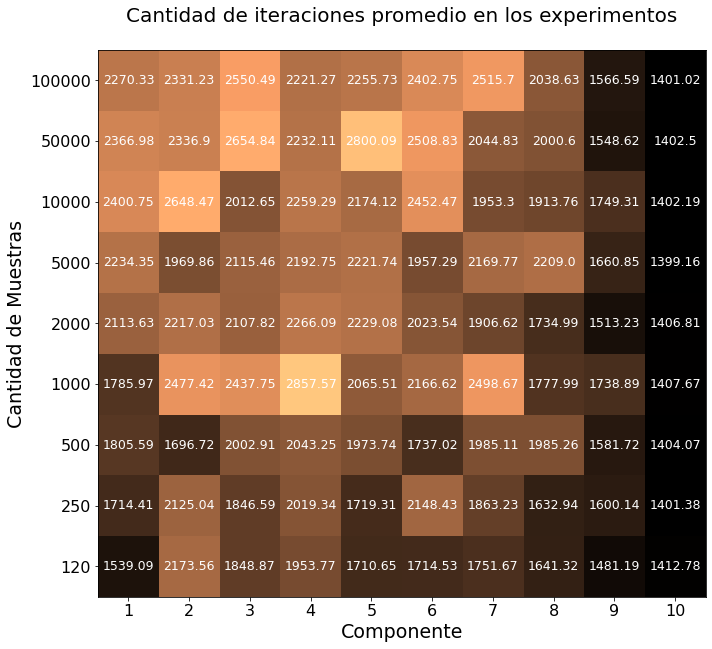

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors


cant_de_muestras = [120,250,500,1000,2000,5000,10000,50000,100000]
componentes = [i+1 for i in range(10)]

promedios.reverse()
cant_de_muestras.reverse()

promedios_de_iteraciones = np.array(promedios)


fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(promedios_de_iteraciones, cmap = 'copper')

# We want to show all ticks...
ax.set_xticks(np.arange(len(componentes)))
ax.set_yticks(np.arange(len(cant_de_muestras)))
# ... and label them with the respective list entries
ax.set_xticklabels(componentes,fontsize=16)
ax.set_yticklabels(cant_de_muestras,fontsize=16)


# Loop over data dimensions and create text annotations.
for i in range(len(cant_de_muestras)):
    for j in range(len(componentes)):
        text = ax.text(j, i, promedios_de_iteraciones[i, j],
                       ha="center", va="center", color="w",fontsize=12.5)



ax.set_title("Cantidad de iteraciones promedio en los experimentos\n",fontsize=20)
plt.xlabel("Componente",fontsize=19)
plt.ylabel("Cantidad de Muestras",fontsize=19)
fig.tight_layout()
plt.show()